# Stable Diffusion Deep Dive

Stable Diffusion is a powerful text-to-image model. There are various websites and tools to make using it as easy as possible. It is also integrated into the Huggingface diffusers library where generating images can be as simple as:

```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]
```

In this notebook we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like

# Setup & Imports

In [2]:
!pip install -q --upgrade transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.6 MB/s eta 0:00:00


In [3]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import torchvision.transforms as T

torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Loading the models

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

# Diffusion loop

<ipython-input-5-dbcc7b5dbc4f>:31: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

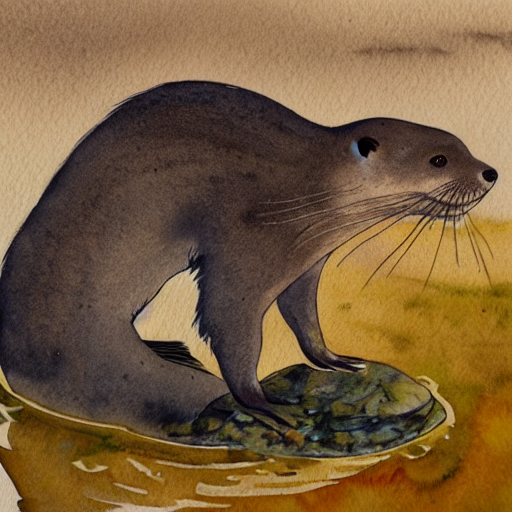

In [5]:
# Some settings
prompt = ["A watercolor painting of an otter"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

# The Autoencoder (AE)

In [6]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [7]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0  72499      0 --:--:-- --:--:-- --:--:-- 72430


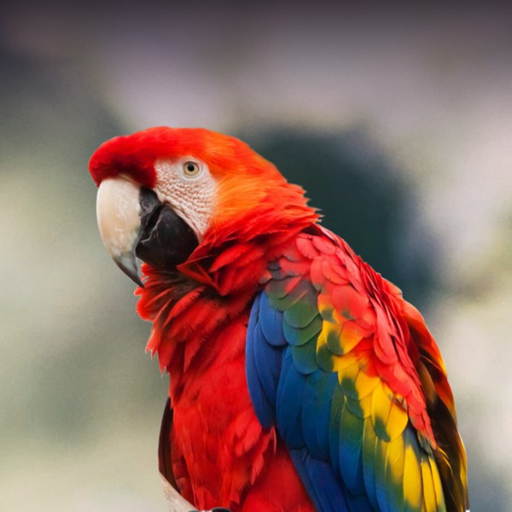

In [8]:
# Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

In [9]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

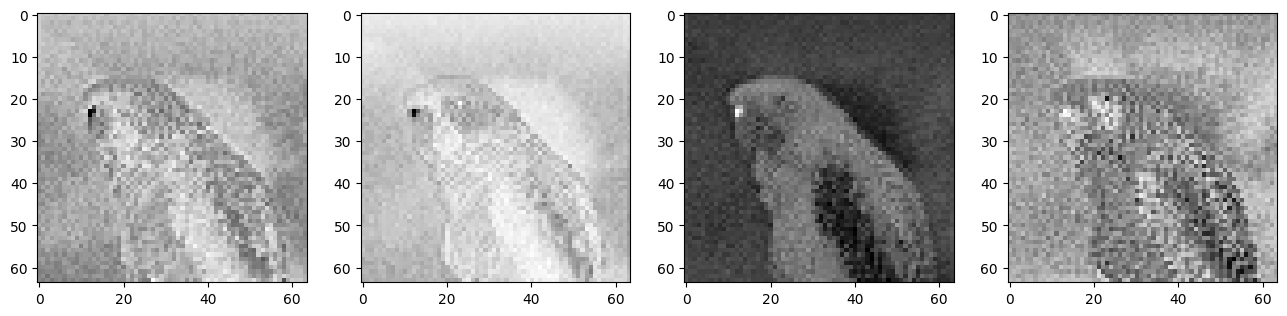

In [10]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

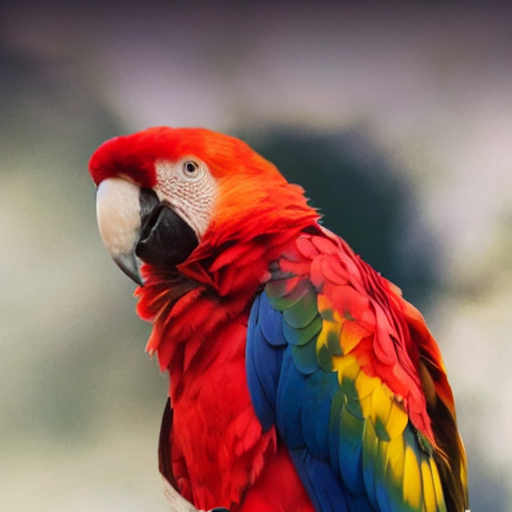

In [11]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

# The Scheduler

In [12]:
# Setting the number of sampling steps:
set_timesteps(scheduler, 15)

In [13]:
# See these in terms of the original 1000 steps used for training:
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])


In [14]:
# Look at the equivalent noise levels:
print(scheduler.sigmas)

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


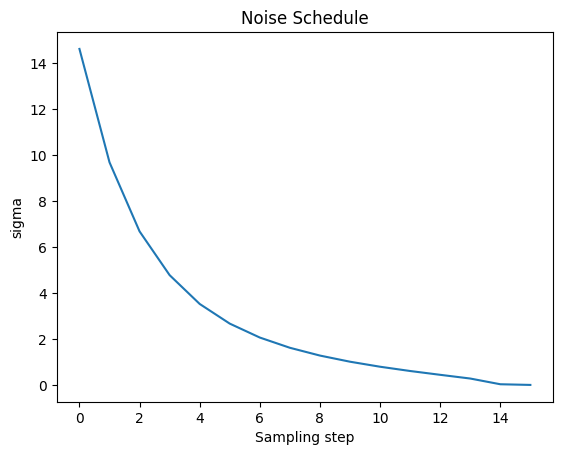

In [15]:
# Plotting this noise schedule:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

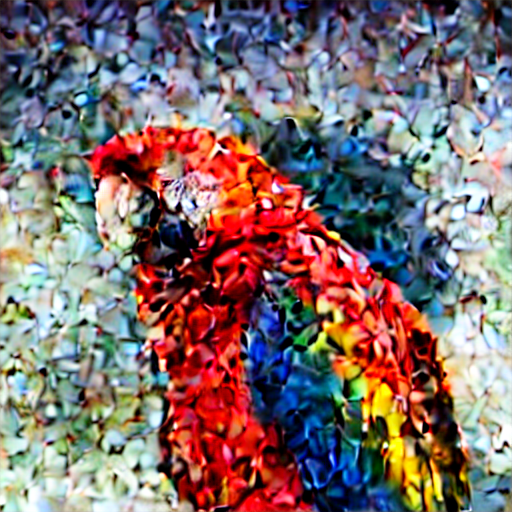

In [16]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 10 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display

# Loop starting from noised version of input (AKA image2image)

  0%|          | 0/50 [00:00<?, ?it/s]

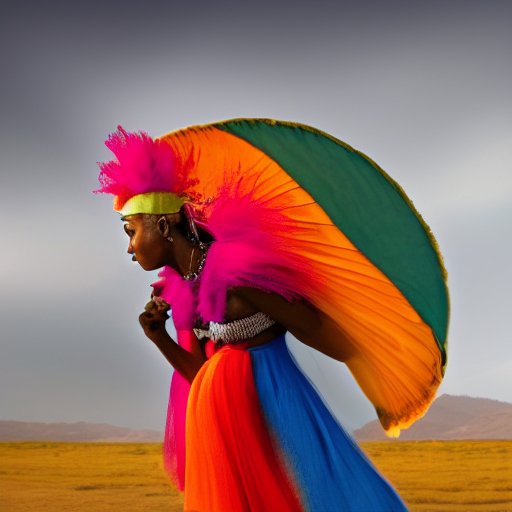

In [17]:
# Settings (same as before except for the new prompt)
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler (setting the number of inference steps)
set_timesteps(scheduler, num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

# Exploring the text -> embedding pipeline

In [18]:
# Our text prompt
prompt = 'A picture of a puppy'

In [19]:
# Turn the text into a sequnce of tokens:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,   320,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [20]:
# See the individual tokens
for t in text_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [21]:
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [22]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

# Token Embeddings

In [23]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [24]:
# Embed a token - in this case the one for 'puppy'
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape # 768-dim representation

torch.Size([768])

In [25]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

# Positional Embeddings

In [26]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [27]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

# Combining token and position embeddings

In [28]:
# And combining them we get the final input embeddings
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [29]:
# The following combines all the above steps (but doesn't let us fiddle with them!)
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [30]:
def build_causal_attention_mask(bsz, seq_len, dtype):
    # lazily create causal attention mask, with full attention between the vision tokens
    # pytorch uses additive attention mask; fill with -inf
    mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))
    mask.triu_(1)  # zero out the lower diagonal
    mask = mask.unsqueeze(1)  # expand mask
    return mask

In [31]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [32]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. In this case just the input embedding of token 2368...
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [33]:
# Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

<ipython-input-33-662cefaa87df>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

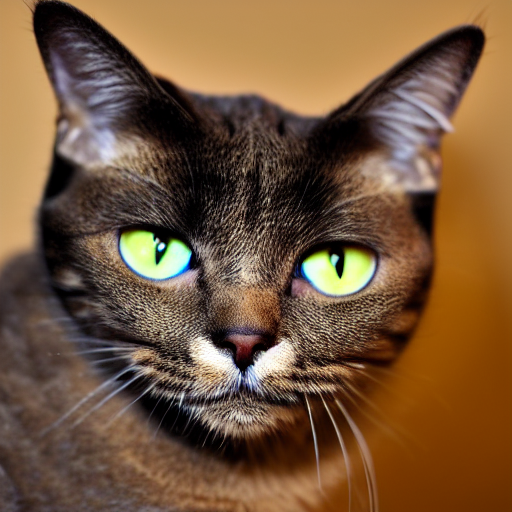

In [34]:
generate_with_embs(modified_output_embeddings)

In [35]:
# In case you're wondering how to get the token for a word, or the embedding for a token:
prompt = 'skunk'
print('tokenizer(prompt):', tokenizer(prompt))
print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([8797], device=torch_device)).shape)

tokenizer(prompt): {'input_ids': [49406, 42194, 49407], 'attention_mask': [1, 1, 1]}
token_emb_layer([token_id]) shape: torch.Size([1, 768])


<ipython-input-33-662cefaa87df>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

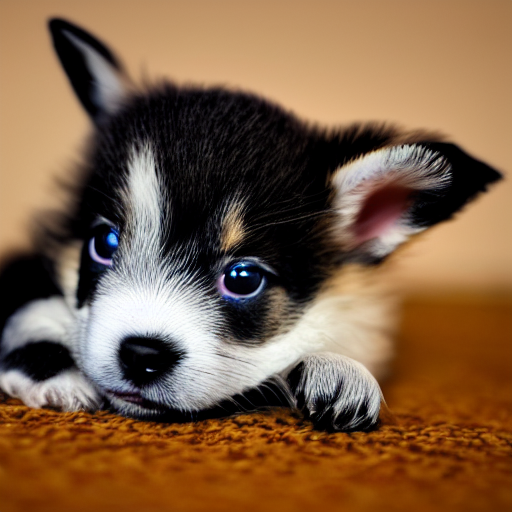

In [36]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. Which is now a mixture of the token embeddings for 'puppy' and 'skunk'
puppy_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
skunk_token_embedding = token_emb_layer(torch.tensor(42194, device=torch_device))
replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# Generate an image with these
generate_with_embs(modified_output_embeddings)

# Textual Inversion

In [38]:
birb_embed = torch.load('birb_style_learned_embeds.bin')
birb_embed.keys(), birb_embed['<birb-style>'].shape

(dict_keys(['<birb-style>']), torch.Size([768]))

<ipython-input-33-662cefaa87df>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

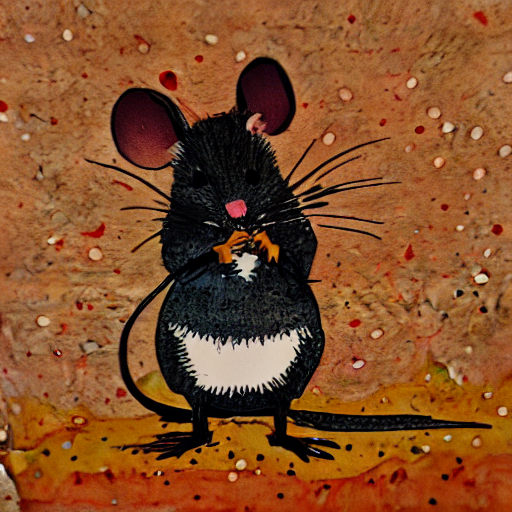

In [39]:
prompt = 'A mouse in the style of puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed['<birb-style>'].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

# Using Different Styles

### Bird Style

In [49]:
def generate(prompt, eos_pos, embeds):
  outputs = []
  i = 10

  for key, value in embeds.items():
    torch.manual_seed(i)
    i+=1

    embed = torch.load(f'{key}_learned_embeds.bin')
    # embed.keys(), embed[f'{value}'].shape

    # Tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)

    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)

    # The new embedding - our special birb word
    replacement_token_embedding = embed[f'{value}'].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, eos_pos] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    img = generate_with_embs(modified_output_embeddings)

    outputs.append(img)
    # break
  return outputs

In [50]:
embeds = {
    "birb_style" : "<birb-style>",
    "matrix" : "<hatman-matrix>",
    "egorey" : "<gorey>",
    "pjablonski_style" : "<pjablonski-style>",
    "fairy_tale_painting_style" : "<fairy-tale-painting-style>",
    "dreamy_painting" : "<dreamy-painting>",
}

In [55]:
seed_value = 10

In [56]:
# def generate(prompt, eos_pos, embed_name):
#   outputs = []
#   i = 10
#   torch.manual_seed(i)
#   embed = torch.load(embed_name)
#   # embed.keys(), embed[f'{value}'].shape

#   # Tokenize
#   text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
#   input_ids = text_input.input_ids.to(torch_device)

#   # Get token embeddings
#   token_embeddings = token_emb_layer(input_ids)
#   # The new embedding - our special birb word
#   replacement_token_embedding = embed.to(torch_device)
#   # Insert this into the token embeddings
#   token_embeddings[0, eos_pos] = replacement_token_embedding.to(torch_device)
#   # Combine with pos embs
#   input_embeddings = token_embeddings + position_embeddings

#   #  Feed through to get final output embs
#   modified_output_embeddings = get_output_embeds(input_embeddings)

#   # And generate an image with this:
#   img = generate_with_embs(modified_output_embeddings)

#   outputs.append(img)
#   # break
#   return outputs

In [69]:
def show_images(images_list):

    keys = list(embeds.keys())
    for c in range(len(images_list)):
        plt.imshow(images_list[c])
        plt.axis('off')
        plt.title(f"Style of {keys[c]}")
        print("\n")
        plt.show()

In [71]:
prompt = 'a dog as a astronaut'
eos_pos = len(prompt.split()) + 1

images = generate(prompt, eos_pos, embeds)

<ipython-input-33-662cefaa87df>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

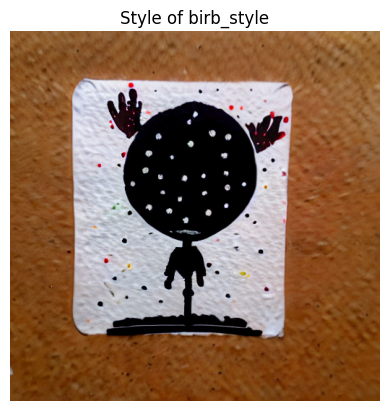

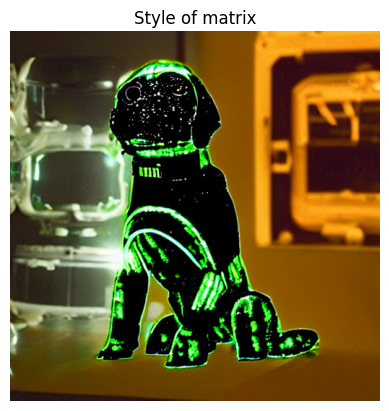

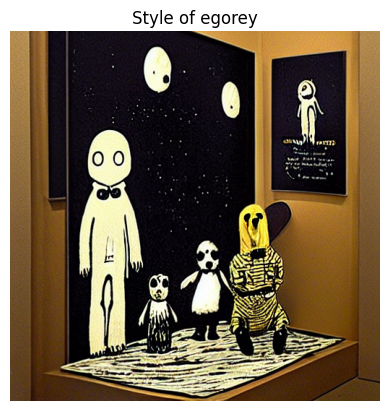

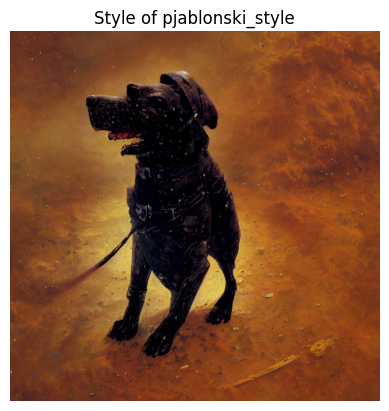

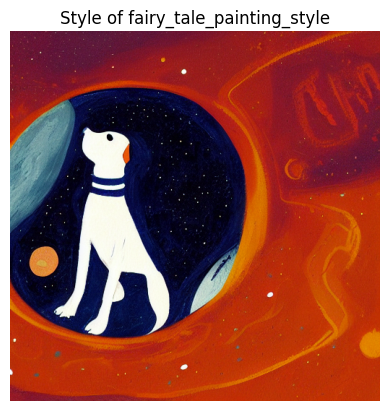

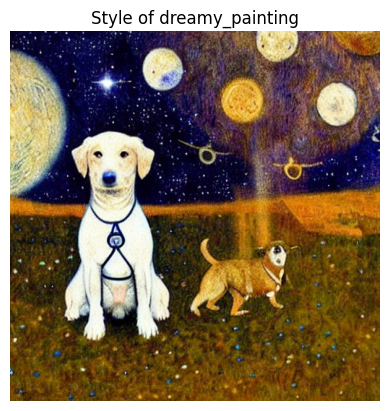

In [72]:
show_images(images)

# Guidance

How can we add some extra control to this generation process?   
At each step, we're going to use our model as before to predict the noise component of x. Then we'll use this to produce a predicted output image, and apply some loss function to this image.

# Blue Loss

In [78]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.7).mean() # [:,2] -> all images in batch, only the blue channel
    return error

<ipython-input-79-03a0904893fd>:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 116.3030776977539
10 loss: 58.83990478515625
20 loss: 41.21751022338867
30 loss: 39.29262161254883
40 loss: 37.93535232543945


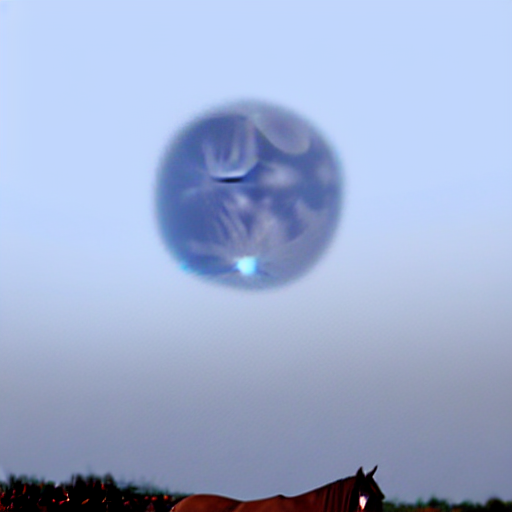

In [79]:
prompt = 'A horse in the moon' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        latents_x0 = latents - sigma * noise_pred
        # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = blue_loss(denoised_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

# Custom loss

In [75]:
import torchvision.transforms as T

In [76]:
# colorfulness_loss

def custom_loss(image):
    # Calculate colorfulness metric (standard deviation of RGB channels)
    std_dev = torch.std(image, dim=(1, 2))
    loss = torch.mean(std_dev)
    return loss

<ipython-input-77-25718cea1818>:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 16.992403030395508
10 loss: 20.578046798706055
20 loss: 17.83574867248535
30 loss: 17.76507568359375
40 loss: 17.96167755126953


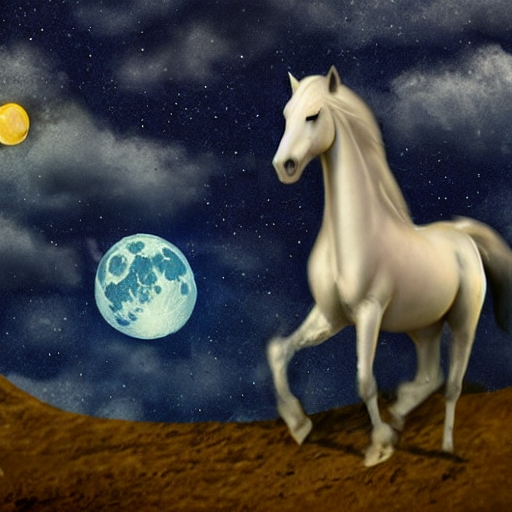

In [77]:
prompt = "A horse in the moon" #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 100.0 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        latents_x0 = latents - sigma * noise_pred
        # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = custom_loss(denoised_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]